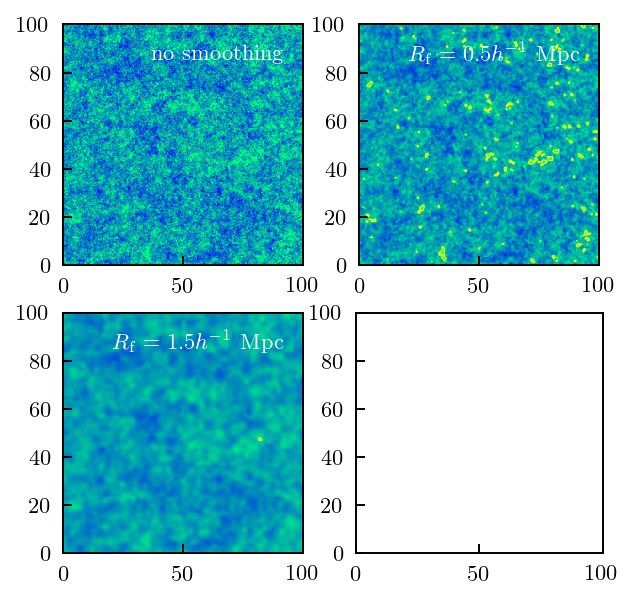

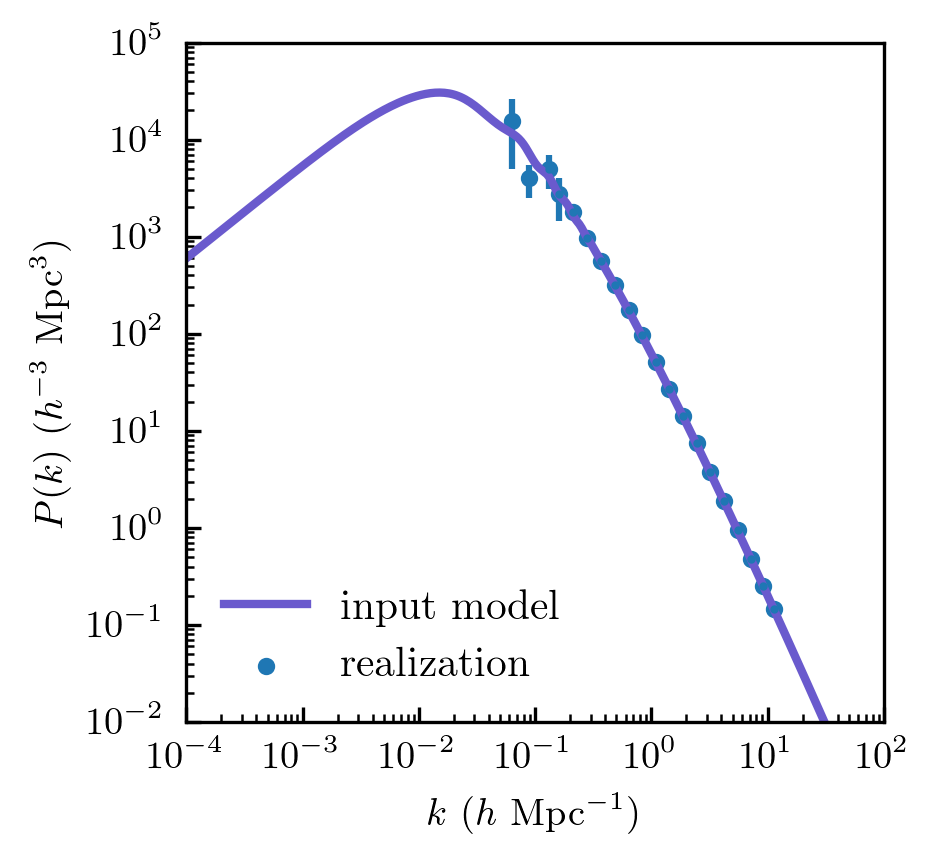

In [32]:
# Here we create a "box" of dimension N
# We fill the box with a density field by drawing from a gaussian
# We normalize the density field by the expeced value for some cosmology and redshift
# We then compare the power spectrum in our box to our cosmological one!
# Beware: this takes some time to run! It will need to run before you can run the next step.

import numpy as np
from numpy.fft import fftn, ifftn, fftfreq
from numpy.random import normal
from matplotlib import pylab as plt
from classcode.plot_utils import plot_pretty
plot_pretty(dpi=300)
from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}

# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
cosmo.interpolation = False

# Make a box with this size in h^{-1} Mpc
Lbox = 100.0

# grid size (change N to 128 if 256 is taking too long)
N=256
N3 = N*N*N
dx = Lbox/N
dxi = 1.0/dx

# set up grid coordinates

# N data points
x1d = np.linspace(0, N-1, N)    

# meshgrid(x,y,z) returns 3-D grid coordinates defined by the vectors x, y, and z
x, y, z = np.meshgrid(x1d, x1d, x1d)

# set random seed; remove if you want new realization every time
np.random.seed(141592653)

# generate a 3D array on our grid of Gaussian numbers with zero mean and unit dispersion
# Go back and look at at our class on Gaussian processes
# The value of delta at a random point is drawn from a gaussian distribution
delta = np.reshape(normal(0.0, 1.0, N3),(N,N,N))

# Fourier transform the delta field
# Read https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftn.html
# What is the difference between fft and fftn?
deltak = fftn(delta)

# get vector of wavenumbers corresponding to modes
k1d = fftfreq(N) * 2.0 * np.pi

# grid of k in Fourier space
kx, ky, kz = np.meshgrid(k1d, k1d, k1d)

# Modulus of wavevector
k = dxi * np.sqrt(kx**2 + ky**2 + kz**2)
k[0,0,0] = np.pi * 2.0 / Lbox

# set up power spectrum for the input model at redshift zini
zini = 30.0

# growth factor at z=30 
gzi = cosmo.growthFactor(30.0)

# Remember that the redshift evolution of P(k) goes like D^2
gzi2 = gzi * gzi

# compute the power spectrum at z=30
Pk  = cosmo.matterPowerSpectrum(k, 'eh98') * gzi2 

# normalize Fourier components using sqrt(P(k))
# Remember how P(k) is defined .....
deltak *= np.sqrt(Pk)

# this is a "DC" or "fundamental mode" corresponding to the constant density in the box. 
# it can be set to any constant
deltak[0,0,0] = 0.0

# Now let's compute P(k) from the box that we created
lk = np.log10(k)
Nb = 20 # number of k bins to use

# P(k) is a weighted histogram of the squares of delta_k amplitudes
Pkj,  lkj = np.histogram(lk, bins=Nb, weights=np.square(np.absolute(deltak)), density=False) 

# <delta^4> for variance of the P(k)
Pkj2, lkj = np.histogram(lk, bins=Nb, weights=np.square(np.square(np.absolute(deltak))), density=False) 
lkaj, lkj = np.histogram(lk, bins=Nb, weights=lk, density=False) 
nj , lkj  = np.histogram(lk, bins=Nb, density=False) 

# Rms error on P(k) due to a finite number of modes
Pkj = Pkj / nj / gzi2 / N3
Pkj2 = Pkj2 / (gzi2*gzi2) / N3 / N3
sPkj = np.sqrt(Pkj2/(nj*(nj-1)) - Pkj**2/(nj-1))
lkaj = lkaj / nj 
kaj = 10.**lkaj

# transform the field back into real space
delta = np.real(ifftn(deltak))

# Let's get the input model spectrum for comparison
lka = np.arange(-4.,3.,0.02)
ka = 10.0**lka
Pka = cosmo.matterPowerSpectrum(ka, 'eh98')

#
# plot P(k) that we created and compare to the expected value
#
Pkjp = np.clip(Pkj,1.e-10,1.e100)
plt.figure(figsize=(3,3))
plt.xscale('log'); plt.yscale('log')
plt.ylim(1.e-2, 1.e5); plt.xlim(1.e-4, 1.e2)
plt.errorbar(kaj, Pkjp, yerr=2.*sPkj, fmt='o', markersize=1.)
plt.scatter(kaj, np.clip(Pkj,1.e-10, 1.e100), s=10., label=r'$\mathrm{realization}$')
plt.plot(ka, Pka, c='slateblue', linewidth=2., label=r'$\mathrm{input\ model}$')
plt.legend(frameon=False, loc='lower left', fontsize=10, scatterpoints=1)
plt.xlabel(r'$k\ (h\rm\ Mpc^{-1})$')
plt.ylabel(r'$P(k)\ (h^{-3}\ \rm Mpc^3)$')
plt.savefig('fig/pk_realization.png', bbox_inches='tight')
plt.show()

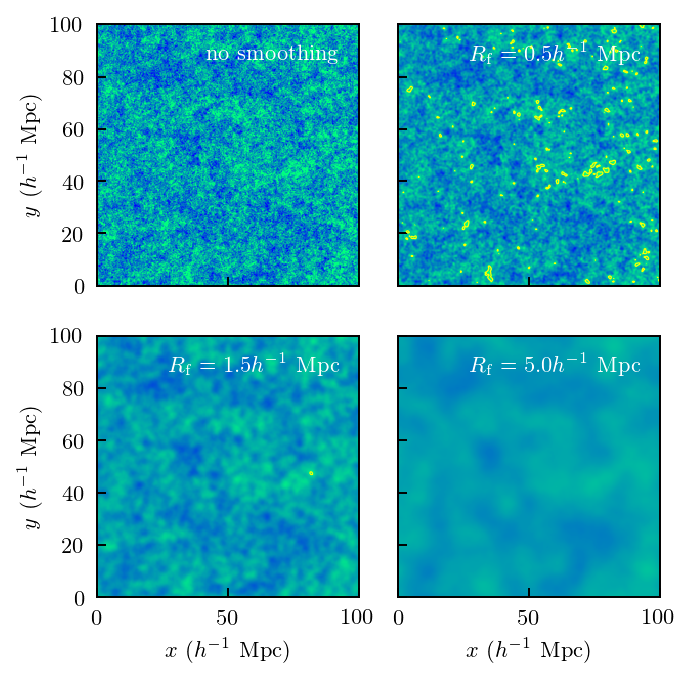

In [33]:
# Now we take our density field, and we smooth it with a top hat filter
# Wfk is the filter

from scipy import signal

# Filter in Fourier Space
def Wfk(kR, filter = 'tophat'):
    """
    Top-hat and Gaussian window functions in Fourier space
    """
    if filter == 'tophat':
        return 3.*(np.sin(kR)-kR*np.cos(kR))/(kR)**3
    elif filter == 'gaussian':
        return np.exp(-0.5*kR**2)
    else:
        print("error in Wfk: routine accepts only tophat or gaussian filter")
        return

#
# plot a slice of the Gaussian density field
#
import matplotlib.ticker as mtick
plot_pretty()
lloc = 'upper right'; lfs = 9; lcol = 'white'; ccol = 'yellow'
fig, ax = plt.subplots(2,2,figsize=(4,4))


for ix in [0,1]:
    for iy in [0,1]:
        ax[ix][iy].set_xlim(0., Lbox); ax[ix][iy].set_ylim(0., Lbox)

dmin = 0.75*np.min(delta[:,:,N//2]); dmax = 0.5*np.max(delta[:,:,N//2])
x1d = Lbox*np.linspace(0, N-1, N)/(N-1)
x, y = np.meshgrid(x1d, x1d)

ax[0][0].imshow(delta[:,:,N//2], cmap='winter', vmin=dmin, vmax=dmax, extent=(0., Lbox, Lbox, 0.))
ax[0][0].plot(0, 0, "-", c='black', label=r'$\mathrm{no\ smoothing}$' )
#ax[0][0].contour(x, y, delta[:,:,N/2]/gzi.T, extent=(0., Lbox, 0., Lbox), linewidths=(0.5), colors=ccol, levels = [1.69])

#ax[0][0].colorbar(fraction=0.04, pad=0.04)
lgnd = ax[0][0].legend(frameon=False, loc=lloc, fontsize=lfs)
for text in lgnd.get_texts():
    text.set_color(lcol);
for item in lgnd.legendHandles:
    item.set_visible(False)
 
# smooth the field with a given filter size and plot
Rfa = [0.5, 1.5, 5.0] #/h Mpc
ix = [0, 1, 1]; iy = [1, 0, 1]
# smooth by a real-space top-hat filter
filter = 'tophat'

for ir, Rf in enumerate(Rfa):
    kR = k*Rf; 
    # A convolution is a multiplication in fourier space
    deltas = fftn(delta) * Wfk(kR, filter)
    deltas = np.real(ifftn(deltas))
    #ax[ix[ir]][iy[ir]].imshow(deltas[:,:,N/2], cmap='winter', vmin=dmin, vmax=dmax, extent=(0., Lbox, 0., Lbox) )
    ax[ix[ir]][iy[ir]].imshow(deltas[:,:,N//2], vmin=dmin, vmax=dmax, 
                              cmap='winter',  extent=(0., Lbox, Lbox, 0.) )
    delta_s = deltas[:,:,N//2]/gzi
    ax[ix[ir]][iy[ir]].contour(x, y, delta_s,  linewidths=(0.5), colors=ccol, 
                               levels = [1.69])
    ax[ix[ir]][iy[ir]].plot(0, 0, "-", c='black', label=r'$R_{\rm f}=%.1fh^{-1}\ \mathrm{Mpc}$'%Rf )
    lgnd = ax[ix[ir]][iy[ir]].legend(frameon=False, loc=lloc, fontsize=lfs)
    for text in lgnd.get_texts():
        text.set_color(lcol);
    for item in lgnd.legendHandles:
        item.set_visible(False)

plt.setp(ax[0][0].get_xticklabels(), visible=False)
plt.setp(ax[0][1].get_xticklabels(), visible=False)
plt.setp(ax[0][1].get_yticklabels(), visible=False)
plt.setp(ax[1][1].get_yticklabels(), visible=False)
ax[0][0].set_ylabel(r'$y\ (h^{-1}\ \mathrm{Mpc})$')
ax[1][0].set_ylabel(r'$y\ (h^{-1}\ \mathrm{Mpc})$')
ax[1][0].set_xlabel(r'$x\ (h^{-1}\ \mathrm{Mpc})$')
ax[1][1].set_xlabel(r'$x\ (h^{-1}\ \mathrm{Mpc})$')

plt.tight_layout()

plt.savefig('fig/gfield_smooth.png', bbox_inches='tight')
plt.show()

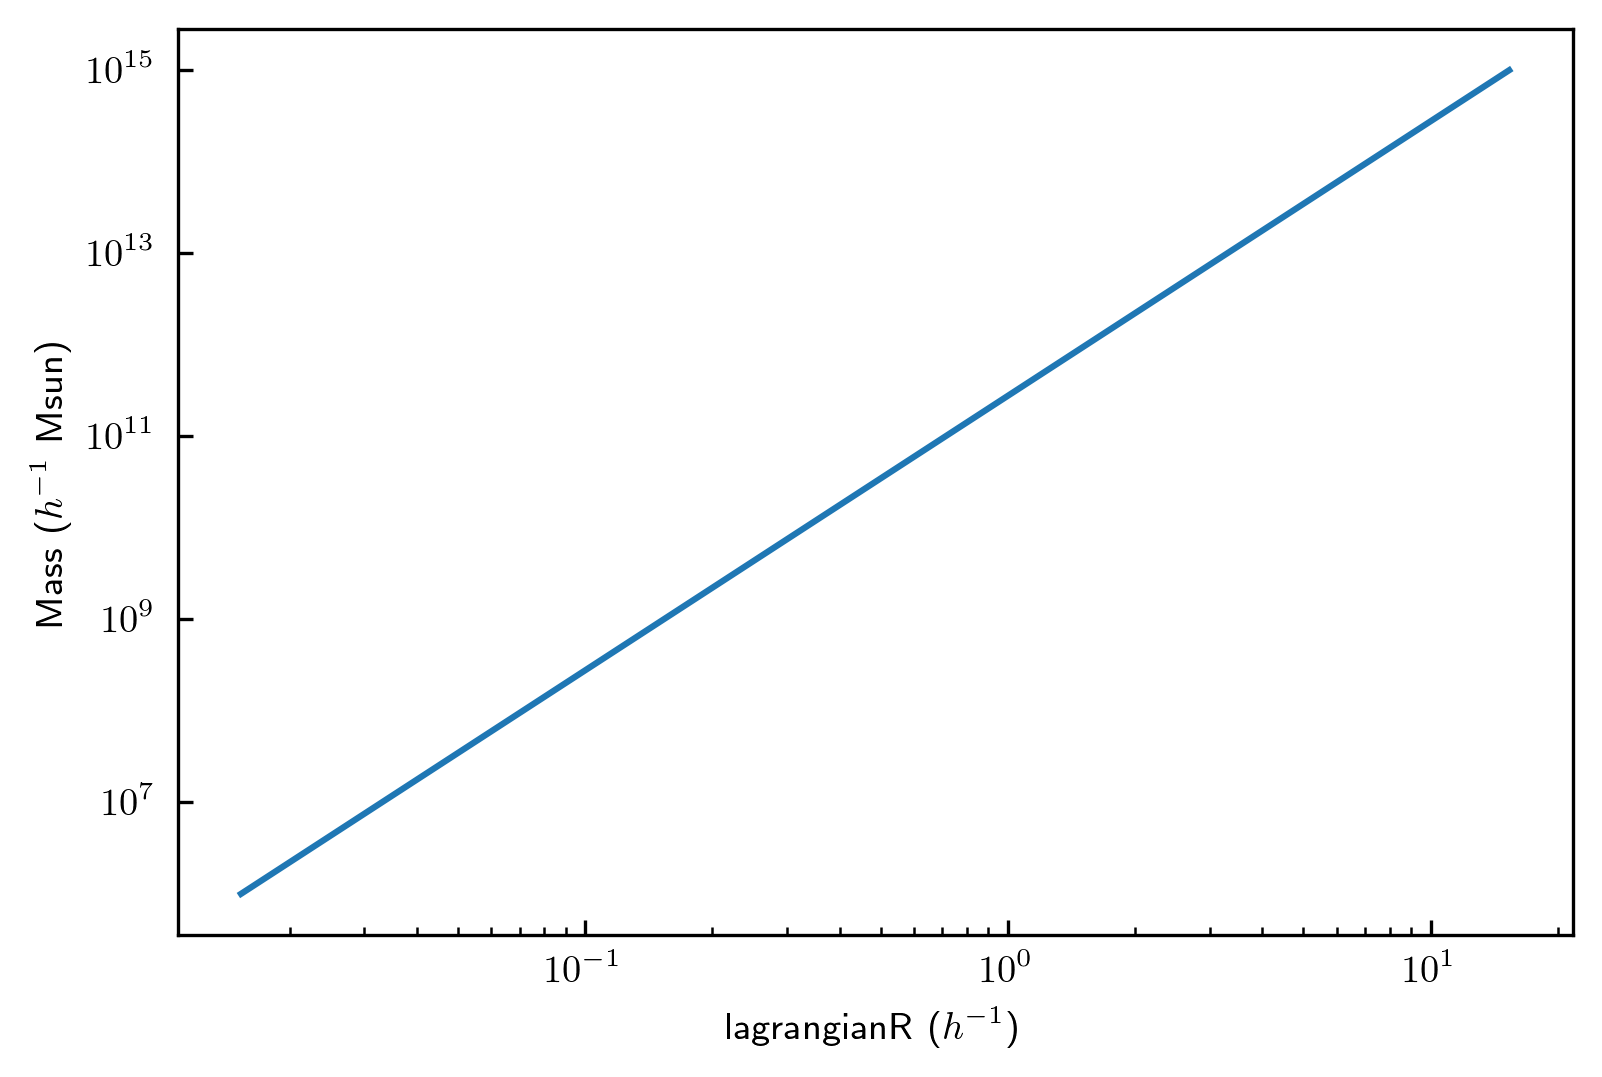

In [34]:
# The cosmology module in colossus
from colossus.cosmology import cosmology

import numpy as np
from matplotlib import pylab as plt
from classcode.plot_utils import plot_pretty
plot_pretty(dpi=300)

# define a vector of cosmological parameters    
my_cosmo_lcdm = {'flat': True, 'H0': 73.0, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.8, 'ns': 0.951}

# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo_lcdm) 
plt.xscale('log')
plt.yscale('log')
# Example
M = np.linspace(1e6,1e15,1000)
#print(cosmo.lagrangianR(M))
plt.xlabel('lagrangianR ($h^{-1}$)')
plt.ylabel('Mass ($h^{-1}$ Msun)')
plt.plot(cosmo.lagrangianR(M),M)
plt.show()

# Put the proper units on R and M in the figures: h^-1 Mpc and h^-1 Msun

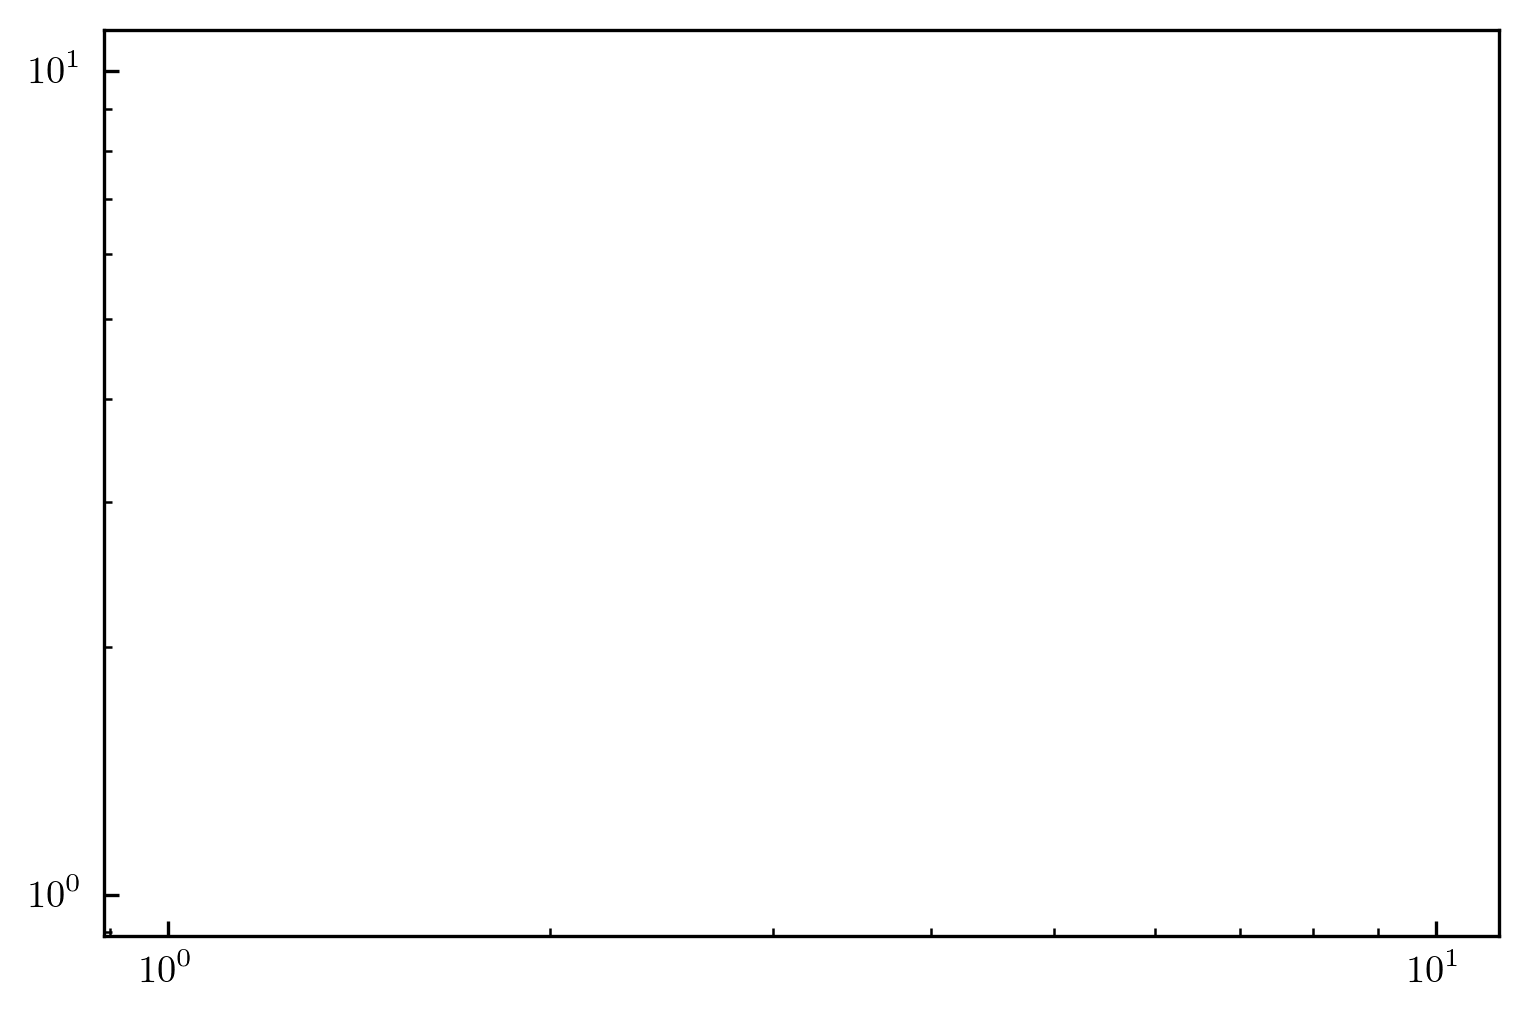

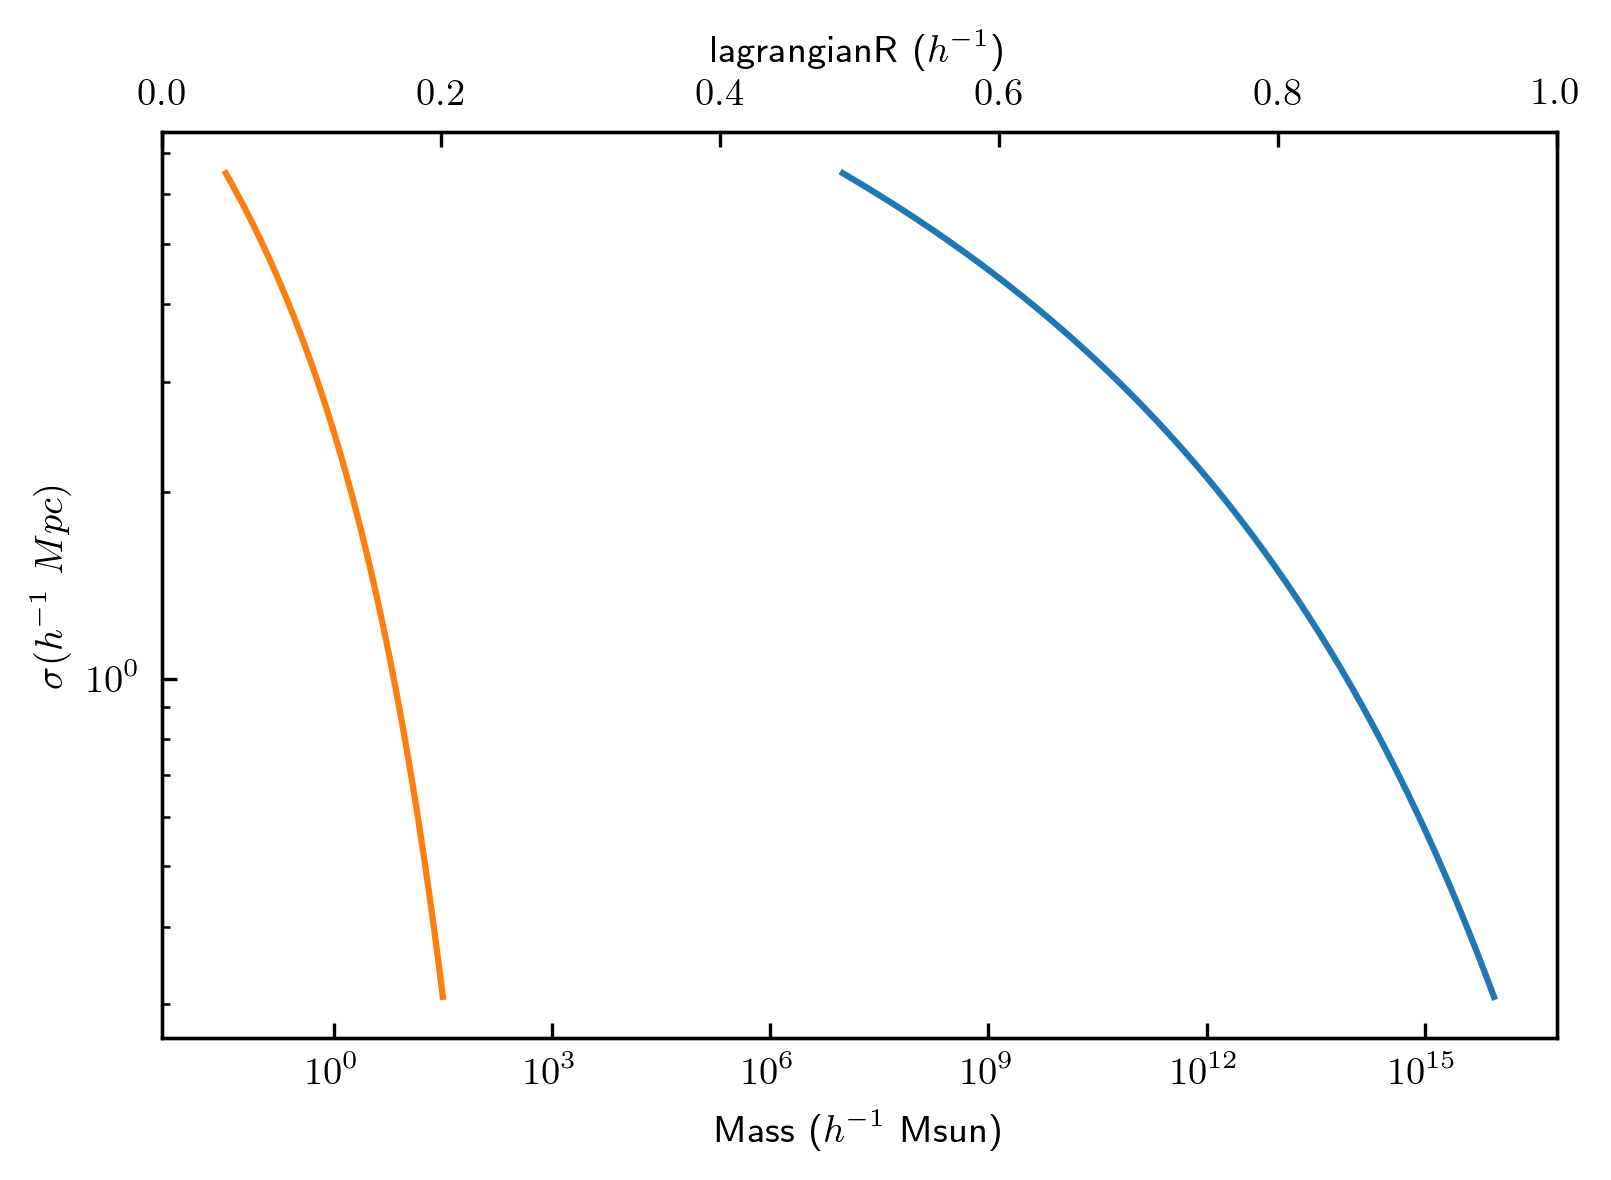

In [144]:
# Your code goes here

# halo masses in /h Msun
lmh = np.arange(7.,16.0,0.05)
mh = np.power(10.,lmh)

# Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
rh = cosmo.lagrangianR(mh)

# compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
sig = cosmo.sigma(rh, z=0., j=0)
plt.xscale('log')
plt.yscale('log')
mpmin = 1.e5 
mpmax = 1.e16
spmin=0.1
spmax = 10.0
rpmin = cosmo.lagrangianR(mpmin)
rpmax = cosmo.lagrangianR(mpmax)


#plt.xlabel('Radius')
#plt.ylabel('$\sigma_{8} (h^{-1} \ Mpc) $')
#plt.plot(rh,sig)
#ax2 = ax.twiny()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mh,sig)
ax.plot(rh,sig)
plt.xscale('log')
plt.yscale('log')
ax2 = ax.twiny()
ax.set_xlabel('Mass ($h^{-1$ Msun)')
ax2.set_xlabel('lagrangianR ($h^{-1}$)')
ax.set_ylabel('$\sigma (h^{-1} \ Mpc)$')
plt.show()

#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(mh,sig)

#ax2.plt(rg,sig)
# Note : Axes.twiny can be used to generate axes that share a *y* axis but have different top and bottom scales.
# Here it could be used to plot sigma as a function of both R and M.
# ax2 = ax.twiny()

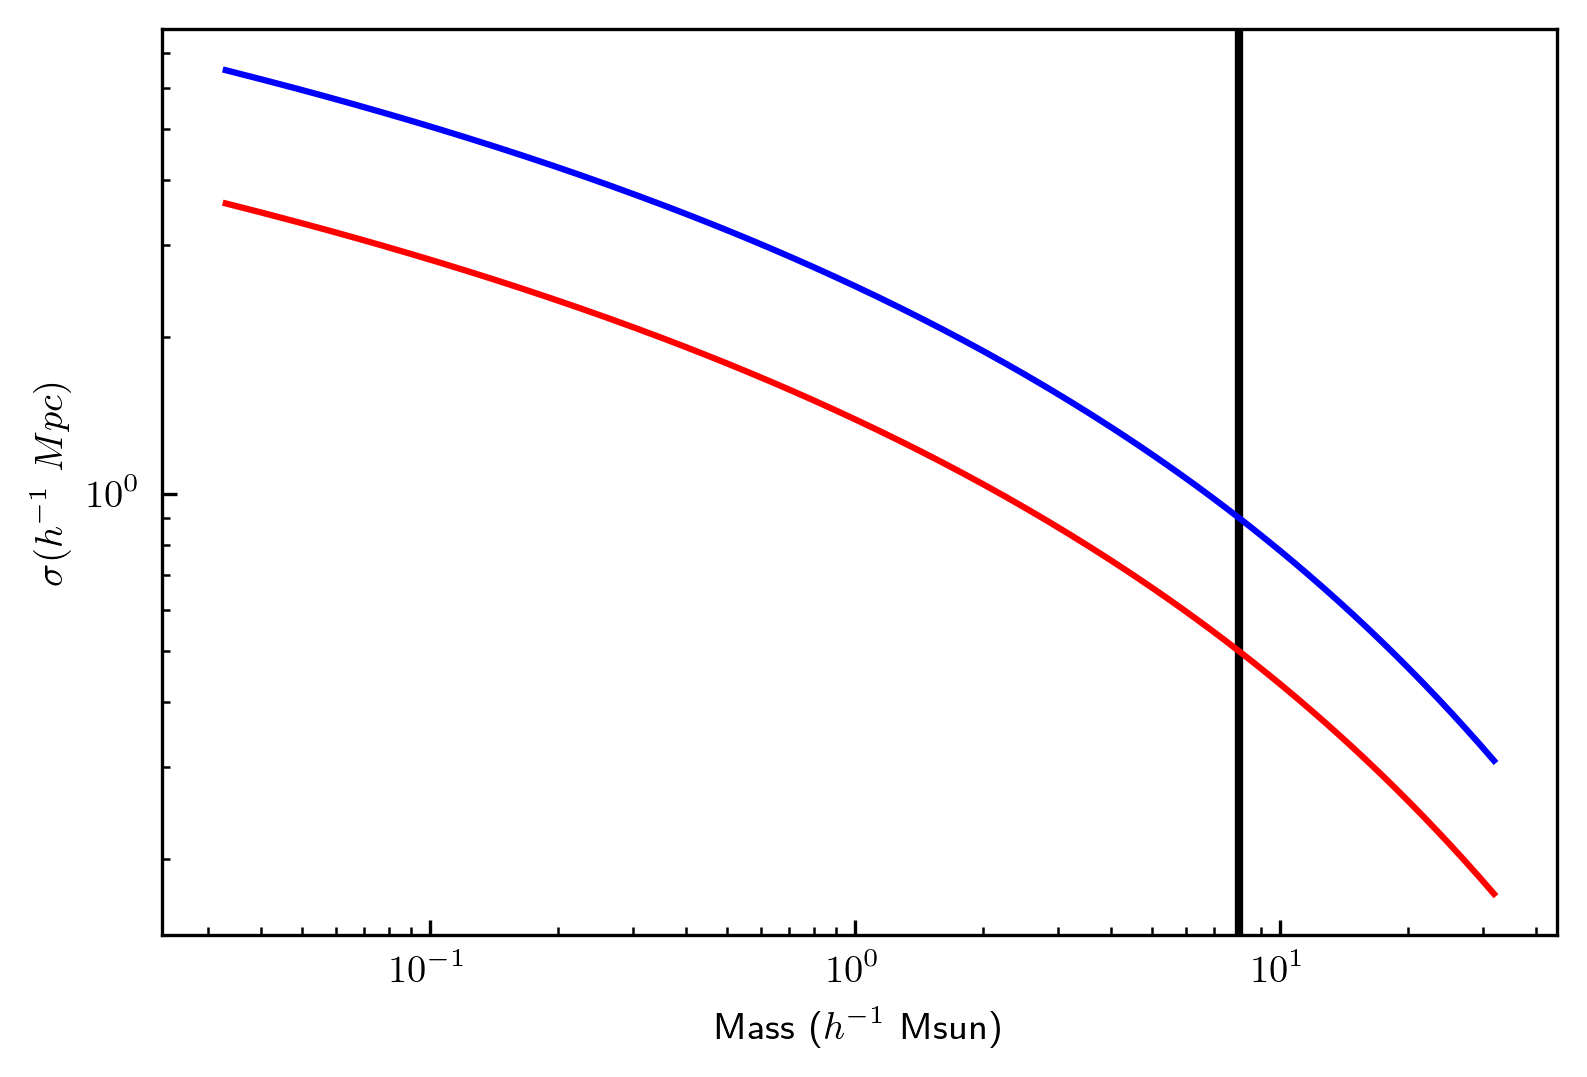

In [125]:
my_cosmo_lcdm = {'flat': True, 'H0': 73.0, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.9, 'ns': 0.951}
my_cosmo_lcdm2 = {'flat': True, 'H0': 73.0, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.5, 'ns': 0.951}
my_cosmo_lcdm3 = {'flat': True, 'H0': 73.0, 'Om0': 0.238, 'Ob0': 0.045714, 'sigma8': 0.74, 'ns': 0.951}
my_cosmo_lcdm4 = {'flat': True, 'H0': 73.0, 'Om0': 0.7, 'Ob0': 0.045714, 'sigma8': 0.74, 'ns': 0.951}
# set my_cosmo to be the current cosmology

# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo_lcdm)
cosmo2 = cosmology.setCosmology('my_cosmo', my_cosmo_lcdm2)
cosmo3 = cosmology.setCosmology('my_cosmo', my_cosmo_lcdm3)
cosmo4 = cosmology.setCosmology('my_cosmo', my_cosmo_lcdm4)

rh = cosmo.lagrangianR(mh)
rh2 = cosmo2.lagrangianR(mh)

# compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
sig = cosmo.sigma(rh, z=0., j=0)
sig2 = cosmo2.sigma(rh, z=0., j=0)
plt.xscale('log')
plt.yscale('log')
mpmin = 1.e5 
mpmax = 1.e16
spmin=0.1
spmax = 10.0
rpmin = cosmo.lagrangianR(mpmin)
rpmax = cosmo.lagrangianR(mpmax)
plt.axvline(x=8, linewidth=2, color='k')
plt.xlabel('Mass ($h^{-1$ Msun)')
plt.ylabel('$\sigma (h^{-1} \ Mpc)$')
#ax2 = ax.twiny()
plt.plot(rh,sig, color = 'b')
plt.plot(rh2,sig2, color = 'r')
plt.show()




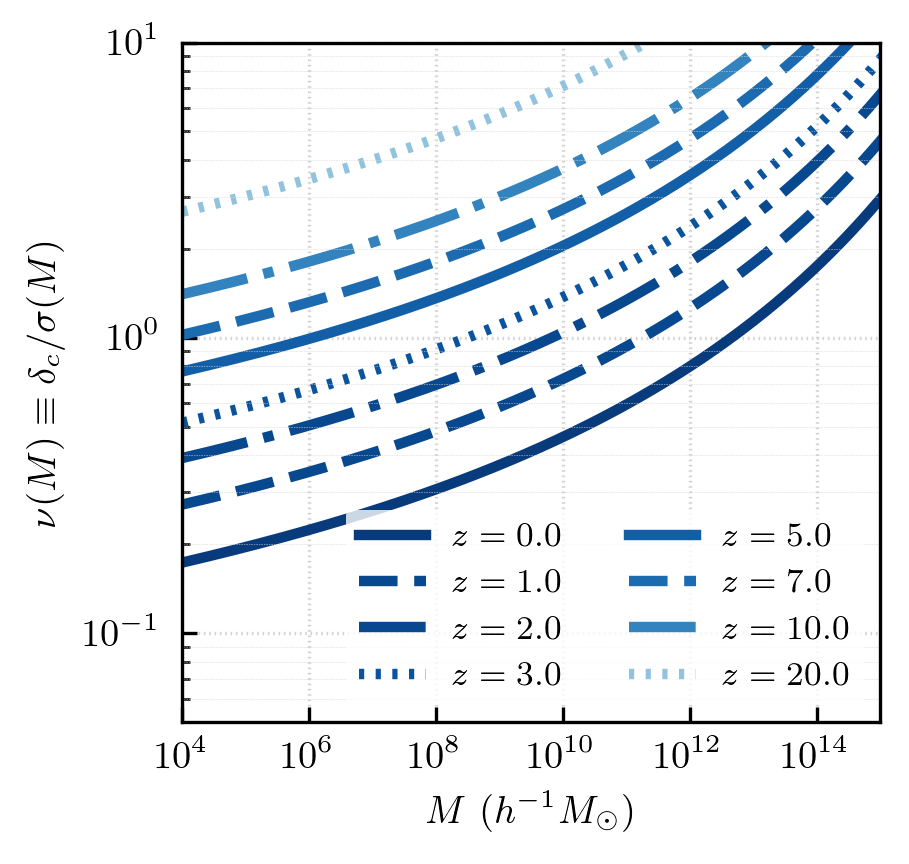

In [121]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# for faster colossus calculations use interpolation
cosmo.interpolation = True

# grid of halo masses in /h Msun
lmh = np.arange(4.,16.5,0.05)
mh = np.power(10.,lmh)

fig = plt.figure(figsize = (3.,3.))
ax = fig.add_subplot(111)
plt.xlabel(r'$M\ (h^{-1} M_{\odot})$'); plt.ylabel(r'$\nu(M)\equiv \delta_c/\sigma(M)$')
plt.yscale('log'); plt.xscale('log')
plt.xlim(1.e4, 1.e15); plt.ylim(5.e-2,10.)

cnorm  = colors.Normalize(vmin=0, vmax=22)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

z = np.array([0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0])
lstyles = ['-','--','-.',':','-','--','-.',':']
nc = np.zeros_like(z)
for i, zd in enumerate(z): nc[i] = np.int(40.*(35.0-zd)/65.0)
color = scalarmap.to_rgba(nc)

for i, zd in enumerate(z):
    nu = cosmo.peakHeight(mh, zd)
    plt.plot(mh,nu,c=color[i],ls=lstyles[i], linewidth=2.5, label=r'$z=%.1f$'%zd)
    
lgnd = plt.legend(loc='lower right', ncol = 2, fontsize=8)
lgnd.get_frame().set_linewidth(0.0)

plt.grid(which='major', linestyle='dotted', c='lightgray')
for ymin in ax.yaxis.get_minorticklocs():
    ax.axhline(y=ymin,lw=0.25,ls=':',c='lightgray')   

plt.savefig('fig/num.png', bbox_inches='tight')
plt.show()

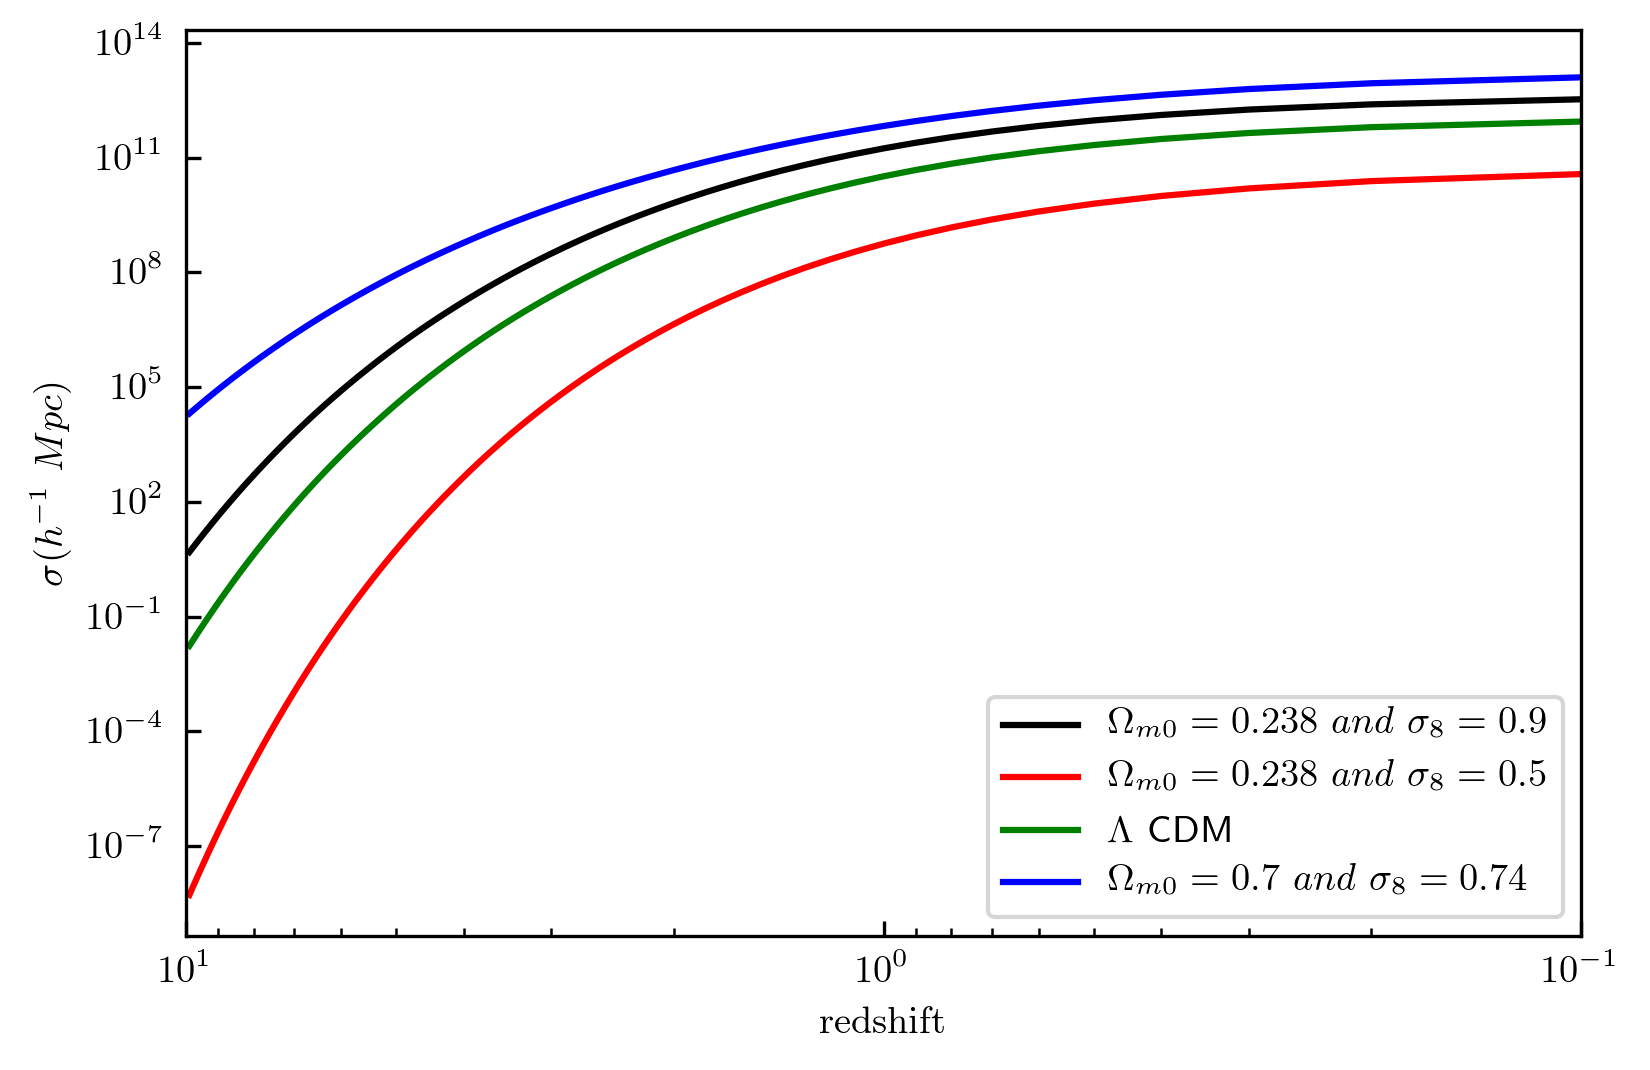

In [150]:
z=np.arange(0.,10.,0.1) 
plt.xscale('log') 
plt.yscale('log') 
nonlinear = [] 
nonlinear2 = [] 
nonlinear3 = [] 
nonlinear4 = [] 
for item in z: 
    k = cosmo.nonLinearMass(item,'tophat','eh98') 
    k2 = cosmo2.nonLinearMass(item,'tophat','eh98') 
    k3 = cosmo3.nonLinearMass(item,'tophat','eh98') 
    k4 = cosmo4.nonLinearMass(item,'tophat','eh98') 
    nonlinear.append(k) 
    nonlinear2.append(k2) 
    nonlinear3.append(k3) 
    nonlinear4.append(k4)
#print (nonlinear,nonlinear2,nonlinear3,nonlinear4)
plt.xlim(10, 0.1)
plt.ylabel('$\sigma (h^{-1} \ Mpc)$')
plt.xlabel(r'$\rm{redshift}$')

plt.plot(z, nonlinear, color = 'k',label = '$\Omega_{m0} = 0.238 \ and \ \sigma_{8} = 0.9$') 
plt.plot(z, nonlinear2,color = 'r', label = '$\Omega_{m0} = 0.238 \ and \ \sigma_{8} = 0.5$') 
plt.plot(z, nonlinear3,color = 'g',label = '$\Lambda$ CDM') 
plt.plot(z, nonlinear4,color = 'b',label = '$\Omega_{m0} = 0.7 \ and \ \sigma_{8} = 0.74$')
plt.legend()
plt.show()